In [1]:
from __future__ import print_function

from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras import callbacks
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Lambda, merge
from keras.models import Model
from keras import backend as K
from keras.regularizers import activity_l2
from keras.utils.visualize_util import plot
from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')
X_train /= 255.0
X_test /= 255.0

# convert class vectors to 1-of-K format
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [3]:
print('train samples: ', X_train.shape)
print('test samples: ', X_test.shape)

train samples:  (60000, 784)
test samples:  (10000, 784)


## Variational AutoEncoder

I arrange from keras sample <br>
https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py

In [4]:
nb_epoch=30
batch_size=100
z_dim =2
epsilon_std = 1.0 # if epsilon is about 0, VAE is closing to AutoEncoder

In [5]:
#Encoder Layer
#I change z_sigma_log to z_sigma from original. But it doesn't influcence the result
x = Input(shape=(784,))
hidden = Dense(500, activation='relu')(x)
z_mean = Dense(z_dim, activation='linear')(hidden)
z_sigma = Dense(z_dim, activation='linear')(hidden)

In [6]:
#Sampling Function
def sampling(args):
    z_mean, z_sigma = args
    epsilon = K.random_normal(shape=(z_dim,), mean=0., std=epsilon_std)
    return z_mean + z_sigma * epsilon

In [7]:
#Sampling
z = Lambda(sampling, output_shape=(z_dim,))([z_mean, z_sigma])

In [8]:
#Decoder Layer
decoder_h = Dense(500, activation='relu')
decoder_mean = Dense(784, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [9]:
#loss function from original
#it's mistake!! check the definition of objectives.binary_crossentropy
def vae_loss_wrong(x, x_decoded_mean):
    reconst_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    latent_loss =  - 0.5 * K.mean(1 + K.log(K.square(z_sigma)) - K.square(z_mean) - K.square(z_sigma), axis=-1)
    return reconst_loss + latent_loss

In [10]:
# define model, but it's wrong
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss_wrong)
encoder = Model(x, z_mean)

In [11]:
#define decoder model
z_in = Input(shape=(z_dim,))
_h_decoded = decoder_h(z_in)
_x_decoded_mean = decoder_mean(_h_decoded)

In [12]:
#decoder
decoder= Model(input=z_in, output=_x_decoded_mean)

In [13]:
#train
hist_vae = vae.fit(X_train, X_train,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        shuffle = True,
                   
        validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 33s - loss: 0.3294 - val_loss: 0.2720
Epoch 2/30
60000/60000 [==============================] - 27s - loss: 0.2713 - val_loss: 0.2663
Epoch 3/30
60000/60000 [==============================] - 26s - loss: 0.2685 - val_loss: 0.2678
Epoch 4/30
60000/60000 [==============================] - 29s - loss: 0.2671 - val_loss: 0.2663
Epoch 5/30
60000/60000 [==============================] - 31s - loss: 0.2662 - val_loss: 0.2680
Epoch 6/30
60000/60000 [==============================] - 30s - loss: 0.2656 - val_loss: 0.2674
Epoch 7/30
60000/60000 [==============================] - 27s - loss: 0.2652 - val_loss: 0.2649
Epoch 8/30
60000/60000 [==============================] - 28s - loss: 0.2648 - val_loss: 0.2640
Epoch 9/30
60000/60000 [==============================] - 27s - loss: 0.2644 - val_loss: 0.2645
Epoch 10/30
60000/60000 [==============================] - 27s - loss: 0.2642 - val_lo

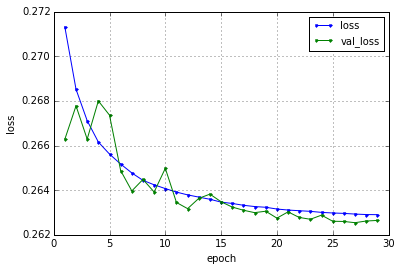

In [14]:
# plot loss
loss = hist_vae.history['loss']
val_loss = hist_vae.history['val_loss']

plt.plot(range(1,nb_epoch), loss[1:], marker='.', label='loss')
plt.plot(range(1,nb_epoch), val_loss[1:], marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

/Users/sho/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


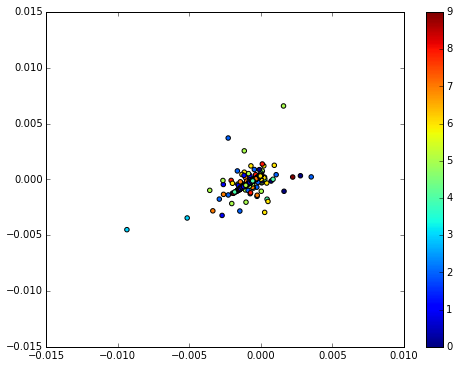

In [15]:
#visualization of latent space
#each digit is apparently not divided
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(8, 6))
plt.scatter(X_test_encoded[:,0],X_test_encoded[:,1], c=np.argmax(y_test,axis=1))
plt.colorbar()
plt.show()

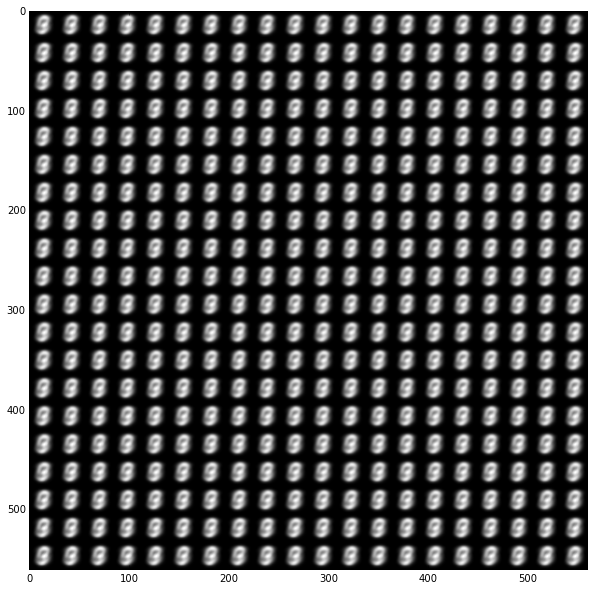

In [16]:
#images of latent space
#it doesn't make sense
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-2, 2] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gray')
plt.show()

In [17]:
#re-define binary_crossentropy
def binary_crossentropy(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_pred, y_true), axis=-1)

In [18]:
#correct vae_loss
def vae_loss(x, x_decoded_mean):
    reconst_loss = K.mean(binary_crossentropy(x, x_decoded_mean),axis=-1)
    latent_loss =  - 0.5 * K.mean(K.sum(1 + K.log(K.square(z_sigma)) - K.square(z_mean) - K.square(z_sigma), axis=-1))
    return reconst_loss + latent_loss

In [19]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [20]:
hist_vae = vae.fit(X_train, X_train,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        shuffle = True,              
        validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 45s - loss: 202.6498 - val_loss: 196.8312
Epoch 2/30
60000/60000 [==============================] - 46s - loss: 191.2784 - val_loss: 185.1866
Epoch 3/30
60000/60000 [==============================] - 40s - loss: 179.5109 - val_loss: 175.6528
Epoch 4/30
60000/60000 [==============================] - 35s - loss: 172.7490 - val_loss: 170.0336
Epoch 5/30
60000/60000 [==============================] - 35s - loss: 169.0520 - val_loss: 167.7020
Epoch 6/30
60000/60000 [==============================] - 31s - loss: 167.0889 - val_loss: 166.0281
Epoch 7/30
60000/60000 [==============================] - 29s - loss: 165.5048 - val_loss: 165.0180
Epoch 8/30
60000/60000 [==============================] - 29s - loss: 164.1590 - val_loss: 163.4913
Epoch 9/30
60000/60000 [==============================] - 29s - loss: 163.3386 - val_loss: 163.3226
Epoch 10/30
60000/60000 [=========================

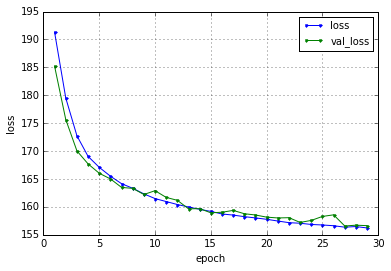

In [21]:
# plot loss
loss = hist_vae.history['loss']
val_loss = hist_vae.history['val_loss']

plt.plot(range(1,nb_epoch), loss[1:], marker='.', label='loss')
plt.plot(range(1,nb_epoch), val_loss[1:], marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

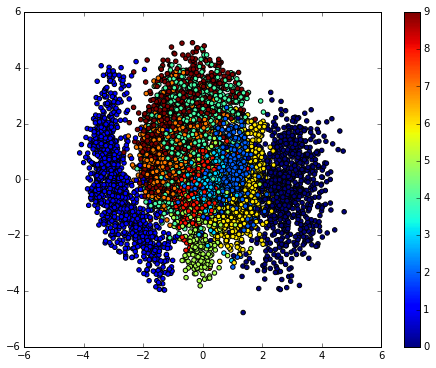

In [22]:
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(8, 6))
plt.scatter(X_test_encoded[:,0],X_test_encoded[:,1], c=np.argmax(y_test,axis=1))
plt.colorbar()
plt.show()

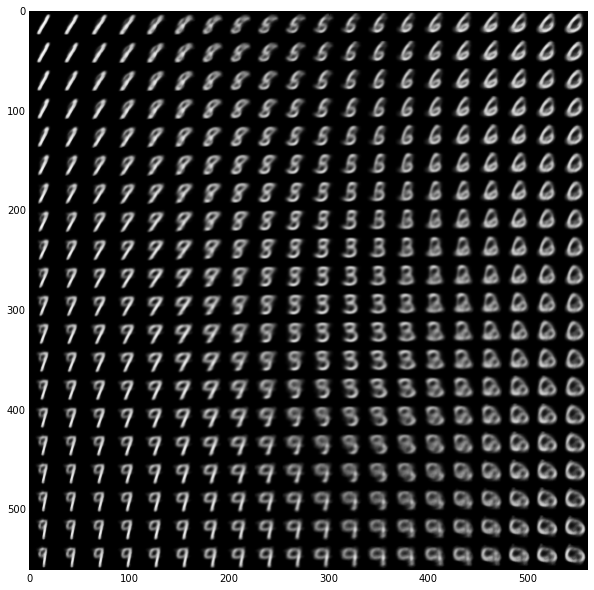

In [23]:
n = 20  
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gray')
plt.show()

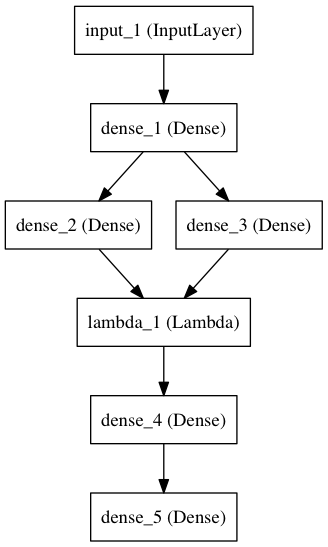

In [24]:
plot(vae, to_file='model.png')
Image(filename='model.png')

## Conditional Variational AutoEncoder

In [25]:
x = Input(shape=(784,))
y = Input(shape=(10,))
merged_enc = merge([x, y], mode='concat')
hidden = Dense(512, activation='relu',activity_regularizer=activity_l2(0.01))(merged_enc)
hidden = Dense(512, activation='relu',activity_regularizer=activity_l2(0.01))(hidden)
z_mean = Dense(z_dim)(hidden)
z_sigma = Dense(z_dim)(hidden)
z = Lambda(sampling)([z_mean, z_sigma])

In [26]:
merged_dec = merge([z, y], mode='concat')
decoder_h = Dense(512, activation='relu',activity_regularizer=activity_l2(0.01))
decoder_h2 = Dense(512, activation='relu',activity_regularizer=activity_l2(0.01))
decoder_mean = Dense(784, activation='sigmoid')
h_decoded = decoder_h(merged_dec)
h_decoded2 = decoder_h2(h_decoded)
x_decoded_mean = decoder_mean(h_decoded2)

In [27]:
cvae = Model([x,y], x_decoded_mean)
cvae.compile(optimizer='rmsprop', loss=vae_loss) # vae_loss is same in M1

In [28]:
z_in = Input(shape=(z_dim,))
merged_ge = merge([z_in, y], mode='concat')
h_decoded_ = decoder_h(merged_ge)
h_decoded2_ = decoder_h2(h_decoded_)
x_reconst = decoder_mean(h_decoded2_)

In [29]:
cdecoder= Model(input=[z_in, y], output=x_reconst)

In [30]:
hist_cvae = cvae.fit([X_train,y_train], X_train,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        shuffle = True,
        validation_data=([X_test,y_test], X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 48s - loss: 164.3412 - val_loss: 144.0699
Epoch 2/30
60000/60000 [==============================] - 50s - loss: 142.1952 - val_loss: 137.5866
Epoch 3/30
60000/60000 [==============================] - 49s - loss: 138.3734 - val_loss: 135.5648
Epoch 4/30
60000/60000 [==============================] - 50s - loss: 136.3117 - val_loss: 134.4146
Epoch 5/30
60000/60000 [==============================] - 49s - loss: 134.9284 - val_loss: 137.1459
Epoch 6/30
60000/60000 [==============================] - 49s - loss: 133.8440 - val_loss: 133.1660
Epoch 7/30
60000/60000 [==============================] - 47s - loss: 133.0383 - val_loss: 132.5356
Epoch 8/30
60000/60000 [==============================] - 48s - loss: 132.4073 - val_loss: 133.5768
Epoch 9/30
60000/60000 [==============================] - 48s - loss: 131.9439 - val_loss: 131.4881
Epoch 10/30
60000/60000 [=========================

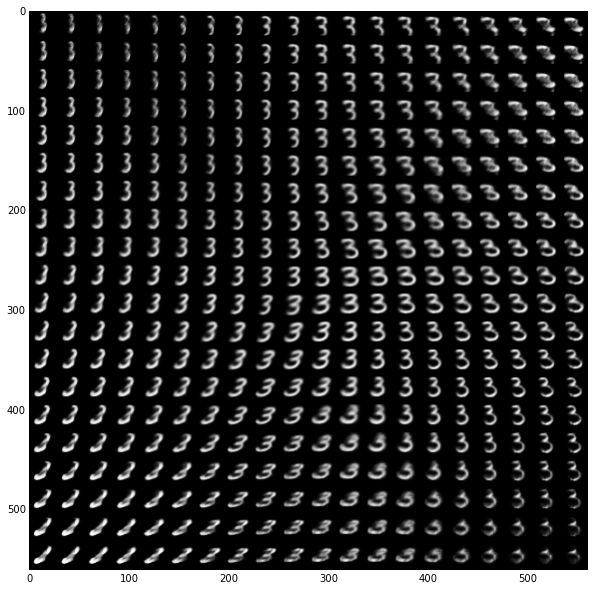

In [31]:
#you can see the variation of digit "3"
n = 20  
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-5, 5] standard deviations
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        y_sample = np.array([[0,0,0,1,0,0,0,0,0,0]])
        x_decoded = cdecoder.predict([z_sample,y_sample])
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gray')
plt.show()

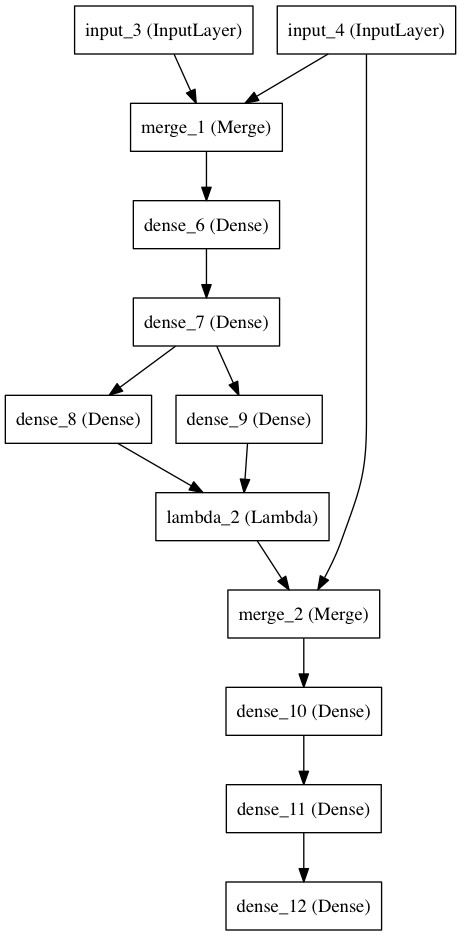

In [32]:
plot(cvae, to_file='model.png')
Image(filename='model.png')